### Sentiment Analysis Using RNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Steps:

1. Importing (or installing) tensorflow and other packages on your system
2. Loading the data from disk
3. Data Preprocessing and visualization
4. Creating the training and testing splits
5. Defining the RNN model architecture
6. Compiling the RNN model
7. Training the model on the training data
8. Evaluating your model on the validation data
9. Making predictions for unseen data

### 1. Importing packages on your system

In [2]:
# import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,LSTM , GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import  Embedding
from tensorflow.keras.models import Sequential
import tensorflow as tf
import itertools

import seaborn as sns
sns.set()

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
print("Tensorflow Version: {}".format(tf.__version__))

Tensorflow Version: 2.15.0


### 2. Load data from disk

In [5]:
# read data
df_train = pd.read_csv("/content/drive/MyDrive/Deep Learning Exam/RNN/datasets/tweets_train.csv")
df_test =  pd.read_csv("/content/drive/MyDrive/Deep Learning Exam/RNN/datasets/tweets_test.csv")

In [6]:
df_train.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source,is_retweet,clean_text,Sentiment
0,Romy 👑,Bolton - England,"Tables turn, bridges burn, you live and learn.",2009-06-15 09:00:39,525,896,3854,False,2020-09-19 15:19:32,['TheSocialDilemma'],Twitter for Android,False,TheSocialDilemma is an eye opener isn t it ple...,Neutral
1,TLynn Peterson,"Black Canyon City, Arizona",Acquired disability ♿ after an accident. Livin...,2013-05-29 00:17:46,5045,5374,48152,False,2020-09-13 00:31:46,['TheSocialDilemma'],Twitter for Android,False,TheSocialDilemma If we don t agree on what is ...,Positive
2,Rutger Kosters,Netherlands,Cloud Solution Architect @NetApp | VCDX #209 |...,2014-10-07 09:34:10,574,251,1070,False,2020-09-09 21:10:33,['TheSocialDilemma'],Twitter for Android,False,Watching TheSocialDilemma scary to see social ...,Negative
3,IDFWU🗯🇿🇼🇿🇦,"East London, South Africa","YOU HAVE OPTIONS, YOU CAN’T JUST TAKE WHAT LIF...",2012-08-22 11:09:06,706,618,1320,False,2020-09-11 04:33:08,NaN,Twitter for Android,False,You check your social media before you pee in ...,Positive
4,Treebel,NaN,NaN,2010-09-25 07:25:31,9,13,55,False,2020-09-17 16:27:38,['thesocialdilemma'],Twitter for iPhone,False,watch thesocialdilemma and see what s actually...,Negative


In [7]:
df_train.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'is_retweet', 'clean_text', 'Sentiment'],
      dtype='object')

### 3. Data Preprocessing and Visualization

In [8]:
print(df_train.shape) # this dataset contain 17000 records and 14 columns for training
print(df_test.shape) # and 3068 records and 13 columns for testing

(17000, 14)
(3068, 13)


<Axes: xlabel='Sentiment', ylabel='count'>

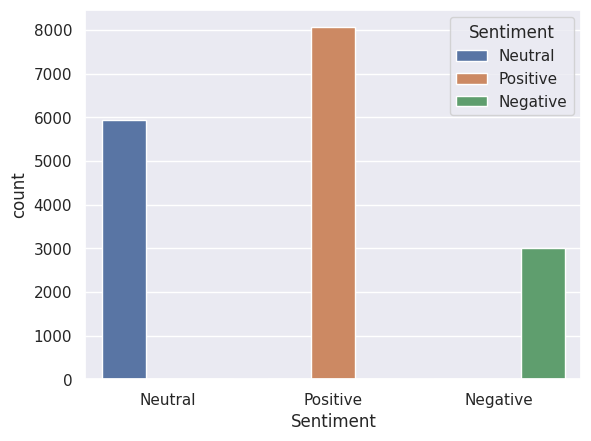

In [10]:
import seaborn as sns
sns.countplot(x="Sentiment", data=df_train, hue="Sentiment")

In [11]:
Neg = round(df_train["Sentiment"].value_counts()[1]/len(df_train) * 100, 2)
Pos = round(df_train["Sentiment"].value_counts()[0]/len(df_train) * 100, 2)
Neut = round(df_train["Sentiment"].value_counts()[2]/len(df_train) * 100, 2)

print('This train_dataset contain {}% Neutral Sentiment tweet'.format(Neg))
print('This train_dataset contain {}% Positive Sentiment tweet'.format(Pos))
print('This train_dataset contain {}% Negative Sentiment tweet'.format(Neut))

This train_dataset contain 34.86% Neutral Sentiment tweet
This train_dataset contain 47.41% Positive Sentiment tweet
This train_dataset contain 17.73% Negative Sentiment tweet


In [12]:
# select relevent columns
df_train = df_train[["clean_text","Sentiment"]]

In [13]:
# create a label columns using manual label encoding
lab = {"Neutral":0,"Positive":1,"Negative":2}
df_train['label']= df_train["Sentiment"].map(lab)
df_train.head()

,clean_text,Sentiment,label
0,TheSocialDilemma is an eye opener isn t it ple...,Neutral,0
1,TheSocialDilemma If we don t agree on what is ...,Positive,1
2,Watching TheSocialDilemma scary to see social ...,Negative,2
3,You check your social media before you pee in ...,Positive,1
4,watch thesocialdilemma and see what s actually...,Negative,2


In [14]:
df_train = df_train[["clean_text", "label"]]

In [15]:
df_train.head()

,clean_text,label
0,TheSocialDilemma is an eye opener isn t it ple...,0
1,TheSocialDilemma If we don t agree on what is ...,1
2,Watching TheSocialDilemma scary to see social ...,2
3,You check your social media before you pee in ...,1
4,watch thesocialdilemma and see what s actually...,2


In [16]:
# check for missing value
df_train.isnull().sum()

clean_text    8
label         0
dtype: int64

In [17]:
# drop missing rows
df_train = df_train.dropna()

df_train.isnull().sum()

clean_text    0
label         0
dtype: int64

In [18]:
# convert training dataset into tensorflow dataset format

train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df_train["clean_text"].values, tf.string),
            tf.cast(df_train['label'].values, tf.int32)
        )
    )
)



In [19]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [20]:
# print first five record from train dataset
for example, label in train_dataset.take(5):
    print("example : ", example.numpy())
    print("label: ", label.numpy())

example :  b'TheSocialDilemma is an eye opener isn t it please ignore the irony of me tweeting about it'
label:  0
example :  b'TheSocialDilemma If we don t agree on what is true or that there is such a thing as truth we re toast This is'
label:  1
example :  b'Watching TheSocialDilemma scary to see social media is fucking up the mental health of Gen X'
label:  2
example :  b'You check your social media before you pee in the morning or whilst you are peeing Those are only 2 choices you ha'
label:  1
example :  b'watch thesocialdilemma and see what s actually going on And share it s scary but 100 true'
label:  2


In [21]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [22]:
# create batches of the dataset

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# now every batch will have 64 samples

In [23]:
# print first batch from train dataset

for example, label in train_dataset.take(1):
    print("example : ", example.numpy())
    print("-----------------------")
    print("label: ", label.numpy())
    print("-----------------------")
    print("total len: ", len(label.numpy()))

example :  [b'TheSocialDilemma is freaking me out so here I am Posting on Twitter'
 b'Hello Highly suggest watching TheSocialDilemma on Netflix and waking yourself up Use Social Media wisely my friends'
 b'Website of the documentary in TheSocialDilemma A MUST WATCH'
 b'I searched for TheSocialDilemma to see what people think of it How ironic Btw it s good and people should watch it'
 b'OurPact has been keeping kids safe online with over 1 2 million families OurPact for scree'
 b'The best and most honest review of TheSocialDilemma'
 b'I m currently watching TheSocialDilemma on and I feel like I m not learning anything tbh I ll post my th'
 b'Just finished watching TheSocialDilemma and YIKES'
 b'TheSocialDilemma GOC Rating 8 5 10 The Technology that connects us Controls us documentary focuses on'
 b'Saw TheSocialDilemma This is not true for India Our IT cells are in control Totally democracyday DontWorryDarling'
 b'A must watch OurPact has been keeping kids safe online with o'
 b'This is

### 4. Creating your training and validation splits

In [24]:
# create validation dataset
val_dataset = train_dataset.take(100)
train_dataset = train_dataset.skip(100)

# select first 100 batch from train dataset for validation data
# each bacth will contain 64 samples and skip first 100 batch from train dataset

### Create the text encoder


The raw text data needs to be processed before it can be used in a model. The simplest way to process text for training is using the text-vectorization layer.

In [25]:
# Create the layer, and pass the dataset text to the layer's .adapt method

VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [26]:
# create vocabulary of words
vocab = np.array(encoder.get_vocabulary())

# print top 20 vocab
vocab[0:20]

array(['', '[UNK]', 'thesocialdilemma', 'the', 'i', 'to', 'on', 'and',
       'a', 'you', 'is', 'it', 'social', 'watch', 'of', 'netflix', 'this',
       's', 'media', 'that'], dtype='<U22')

In [27]:
encoded_example = encoder("This is a nice pen!").numpy()

In [28]:
encoded_example

array([ 16,  10,   8, 828,   1])

In [29]:
encoder.get_vocabulary()[1]

'[UNK]'

### 5. Defining your RNN model architecture

In [30]:
# creating RNN model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])


### 6. Compiling your RNN model

In [32]:
# compile the model

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### 7. Training your model on your training data

In [33]:
EPOCHS = 25

results =model.fit(train_dataset,
                  epochs=EPOCHS,
                  validation_data=val_dataset)

Epoch 1/25
166/166 [==============================] - 19s 92ms/step - loss: 1.0268 - accuracy: 0.4846 - val_loss: 0.9800 - val_accuracy: 0.5638
Epoch 2/25
166/166 [==============================] - 11s 66ms/step - loss: 0.9207 - accuracy: 0.6094 - val_loss: 0.8588 - val_accuracy: 0.6366
Epoch 3/25
166/166 [==============================] - 10s 59ms/step - loss: 0.7911 - accuracy: 0.6717 - val_loss: 0.7234 - val_accuracy: 0.7080
Epoch 4/25
166/166 [==============================] - 8s 51ms/step - loss: 0.6857 - accuracy: 0.7283 - val_loss: 0.6583 - val_accuracy: 0.7431
Epoch 5/25
166/166 [==============================] - 10s 58ms/step - loss: 0.6005 - accuracy: 0.7710 - val_loss: 0.5696 - val_accuracy: 0.7850
Epoch 6/25
166/166 [==============================] - 7s 44ms/step - loss: 0.5414 - accuracy: 0.7936 - val_loss: 0.5014 - val_accuracy: 0.8163
Epoch 7/25
166/166 [==============================] - 7s 41ms/step - loss: 0.4755 - accuracy: 0.8249 - val_loss: 0.4521 - val_accuracy: 0.

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 76611 (299.26 KB)
Trainable params: 76611 (299.26 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

### 8. Evaluating your model on your test data

In [35]:
test_loss, test_acc = model.evaluate(train_dataset)

166/166 [==============================] - 1s 6ms/step - loss: 0.2032 - accuracy: 0.9401


In [36]:
print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

Test Loss: 0.20317043364048004
Test Accuracy: 0.9401435256004333


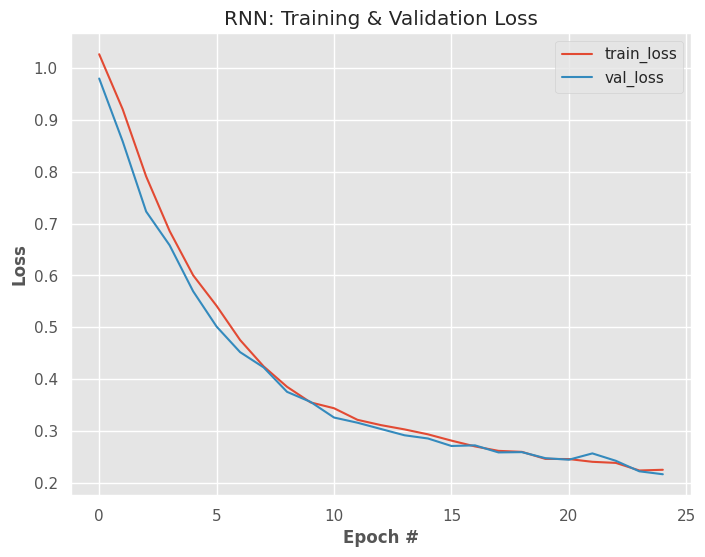

In [38]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [8,6])
plt.plot(N, results.history["loss"], label="train_loss")
plt.plot(N, results.history["val_loss"], label="val_loss")
plt.title("RNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

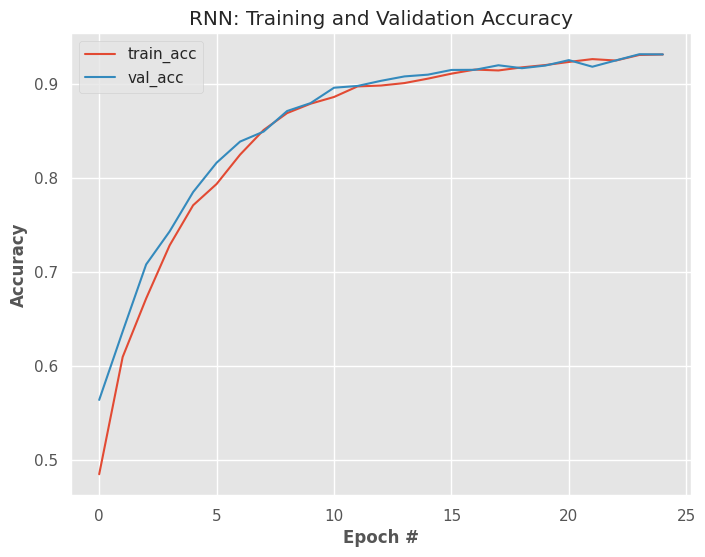

In [39]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [8,6])
plt.plot(N, results.history["accuracy"], label="train_acc")
plt.plot(N, results.history["val_accuracy"], label="val_acc")
plt.title("RNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

In [40]:
# predict on a sample text

sample_text = ("The movie was Good, I would recommend this movie.")

prediction = model.predict(np.array([sample_text]))
print(prediction)

# add final prediction to dataframe


if np.argmax(prediction) == 0:
    print("Neutral")
elif np.argmax(prediction) == 1:
    print("Positive")
else:
    print("Negative")

1/1 [==============================] - 0s 326ms/step
[[3.4189428e-04 9.9781138e-01 1.8467725e-03]]
Positive


### 9. Saving the model

In [44]:
# save the model to disk
print("[INFO] serializing network...")
model.save("/content/drive/MyDrive/Deep Learning Exam/RNN/sentiment_RNN.model", save_format="tf")

[INFO] serializing network...


### 10. Making predictions for unseen data

In [45]:
# check missing value
df_test.isnull().sum()

user_name             0
user_location       601
user_description    221
user_created          0
user_followers        0
user_friends          0
user_favourites       0
user_verified         0
date                  0
hashtags            648
source                0
is_retweet            0
clean_text            1
dtype: int64

In [46]:
# Drop rows with any NaN in the clean text column only
df_test = df_test.dropna(how='any', subset=['clean_text'])

In [47]:
# check missing value
df_test.isnull().sum()

user_name             0
user_location       600
user_description    221
user_created          0
user_followers        0
user_friends          0
user_favourites       0
user_verified         0
date                  0
hashtags            647
source                0
is_retweet            0
clean_text            0
dtype: int64

In [48]:
# prediction on unseen data
y_pred = model.predict(np.array(df_test["clean_text"]))

96/96 [==============================] - 1s 6ms/step


In [49]:
y_pred[:10] # confidence for each class

array([[8.8959843e-01, 7.8279547e-02, 3.2122079e-02],
       [3.8768008e-01, 7.6334611e-02, 5.3598535e-01],
       [1.3139559e-04, 9.5881486e-01, 4.1053656e-02],
       [9.8084944e-01, 1.3568684e-02, 5.5818777e-03],
       [2.0838988e-03, 9.4404250e-01, 5.3873628e-02],
       [3.9151093e-04, 9.9046797e-01, 9.1404775e-03],
       [8.0698079e-01, 1.8341947e-01, 9.5997769e-03],
       [9.3943334e-01, 5.0754528e-02, 9.8121688e-03],
       [1.6466539e-02, 9.6461928e-01, 1.8914154e-02],
       [1.3034957e-03, 9.4918430e-01, 4.9512219e-02]], dtype=float32)

In [50]:
# create new column for prediction
df_test["Predicted_label"] = np.argmax(y_pred, axis=1)

In [51]:
df_test.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source,is_retweet,clean_text,Predicted_label
0,Doug Webb,Probably Europe,"I develop methods for effective cooperation, w...",2015-12-12 15:22:58,157,228,496,False,2020-09-15 22:53:36,"['theSocialDilemma', 'joinMastodon']",Twitter Web App,False,Watch theSocialDilemma then joinMastodon,0
1,Dan Reynish,"Medicine Hat, Alberta",News Anchor at Noon and 5 pm on CHAT TV. Canad...,2011-09-10 12:17:10,1722,2500,13912,False,2020-09-12 04:43:03,['WeTheNorth'],Twitter Web App,False,With the 2019 2020 NBA season officially over ...,2
2,🌤,NaN,NaN,2011-06-01 02:23:57,880,585,205,False,2020-09-19 07:06:53,['TheSocialDilemma'],Twitter for iPhone,False,if you want to really know about people go tal...,1
3,“IT IS WHAT IT IS.”🇰🇪🇳🇿🇺🇸,WA,Heliophile🌞☀️• #Rugby • Wildlifer • #HIV • #So...,2009-04-17 13:35:02,1143,2692,11999,False,2020-09-12 18:28:18,"['TheSocialDilemma', 'Netflix']",Twitter for iPhone,False,Have you watched TheSocialDilemma on Netflix,0
4,Mahima Sood,NaN,Amy Dunne X Holly Golightly || Data Scientist ...,2018-01-26 21:57:22,18,65,263,False,2020-09-12 18:48:53,['TheSocialDilemma'],Twitter for iPhone,False,Highly recommend TheSocialDilemma on,1


In [52]:
df_test["Predicted_label"].value_counts()

1    1492
0    1096
2     479
Name: Predicted_label, dtype: int64

In [53]:
def label(a):
    if a==0:
        return "Neutral"
    elif a==1:
        return "Positive"
    else:
        return "Negative"

In [54]:
df_test["Predicted_label"] = df_test["Predicted_label"].apply(lambda a : label(a))

In [55]:
df_test.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source,is_retweet,clean_text,Predicted_label
0,Doug Webb,Probably Europe,"I develop methods for effective cooperation, w...",2015-12-12 15:22:58,157,228,496,False,2020-09-15 22:53:36,"['theSocialDilemma', 'joinMastodon']",Twitter Web App,False,Watch theSocialDilemma then joinMastodon,Neutral
1,Dan Reynish,"Medicine Hat, Alberta",News Anchor at Noon and 5 pm on CHAT TV. Canad...,2011-09-10 12:17:10,1722,2500,13912,False,2020-09-12 04:43:03,['WeTheNorth'],Twitter Web App,False,With the 2019 2020 NBA season officially over ...,Negative
2,🌤,NaN,NaN,2011-06-01 02:23:57,880,585,205,False,2020-09-19 07:06:53,['TheSocialDilemma'],Twitter for iPhone,False,if you want to really know about people go tal...,Positive
3,“IT IS WHAT IT IS.”🇰🇪🇳🇿🇺🇸,WA,Heliophile🌞☀️• #Rugby • Wildlifer • #HIV • #So...,2009-04-17 13:35:02,1143,2692,11999,False,2020-09-12 18:28:18,"['TheSocialDilemma', 'Netflix']",Twitter for iPhone,False,Have you watched TheSocialDilemma on Netflix,Neutral
4,Mahima Sood,NaN,Amy Dunne X Holly Golightly || Data Scientist ...,2018-01-26 21:57:22,18,65,263,False,2020-09-12 18:48:53,['TheSocialDilemma'],Twitter for iPhone,False,Highly recommend TheSocialDilemma on,Positive


In [56]:
#df_test.to_csv("Test Predictioin.csv", index=False)